#Step 1: Install Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

#Machine Learning
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import metrics

#Install TALIB---------------------------------------------------------
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install

!pip install Ta-Lib
import talib as ta

#Install Pyfolio------------------------------------------------------
!pip install pyfolio
import pyfolio as pf

#Install Yahoo Finance------------------------------------------------
!pip install yfinance
import yfinance as yf

<ipython-input-1-38b72e161307>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


--2023-08-09 07:44:04--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-08-09 07:44:04--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-08-09 07:44:05--  http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving nchc.dl.sourceforge.n

/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(




---



#Step 2: Import Dataset & Plot

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,32.799999,32.830002,32.720001,32.790001,30.541002,1610600
2022-01-04,33.049999,33.779999,33.009998,33.709999,31.397900,5285200
2022-01-05,33.799999,33.849998,33.070000,33.240002,30.960135,4654600
2022-01-06,32.980000,33.820000,32.959999,33.820000,31.500351,4700100
2022-01-07,34.150002,34.369999,34.040001,34.369999,32.012630,5028600
...,...,...,...,...,...,...
2023-08-02,33.799999,34.299999,33.720001,33.840000,33.840000,4064300
2023-08-03,34.130001,34.340000,33.660000,33.759998,33.759998,3676400
2023-08-04,34.000000,34.480000,34.000000,34.250000,34.250000,4774800


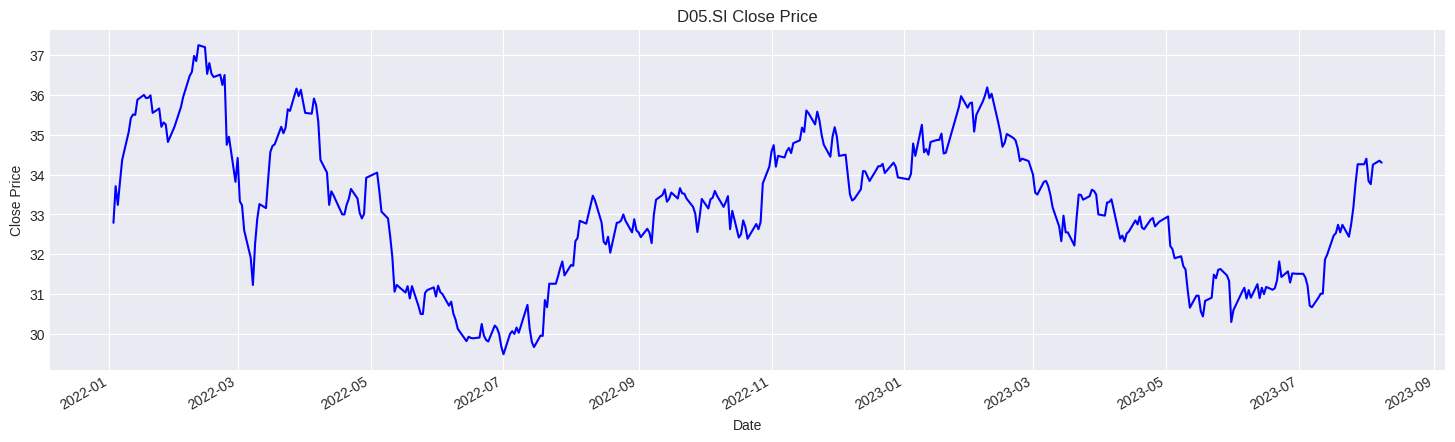

In [2]:
ticker = 'D05.SI'
data = yf.download(ticker,start='2022-01-01')
display(data)

#we only want the Close price
#data = pd.DataFrame(data['Close'])
#display(data)

#Plot---------------------------------------
data.Close.plot(figsize=(18,5), color='b')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title(f'{ticker} Close Price' )
plt.show()



---



#Step 3: Define Features and Target

In [3]:
def get_target_features(data):

    # -------------------------------------------------------------
    # Define Features (X)
    #Volatility
    #(we use the pct_change() to get the Volatility)
    data['PCT_CHANGE'] = data['Close'].pct_change()
    data['VOLATILITY'] = data.rolling(14)['PCT_CHANGE'].std()*100

    #Correlation
    #(we use the SMA to get the CORR)
    data['SMA'] = ta.SMA(data['Close'],14)
    data['CORR'] = ta.CORREL(data['Close'], data['SMA'], 14)

    #RSI
    data['RSI'] = ta.RSI(data['Close'].values, timeperiod=14)

    #ADX
    data['ADX'] = ta.ADX(data['High'].values, data['Low'].values, data['Open'].values, timeperiod=14)


    # ------------------------------------------------------------
    # Define Target (y)
    data['Returns_4_Tmrw'] = data['Close'].pct_change().shift(-1)

    # Create the signal column
    data['Actual_Signal'] = np.where(data['Returns_4_Tmrw'] > 0, 1, 0)

    data = data.dropna()

    return data['Actual_Signal'], data[['VOLATILITY', 'CORR', 'RSI', 'ADX']]




---



#Step 4: Train Test Split

In [4]:
y, X = get_target_features(data)

split = int(0.8*len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]



---



#Step 5: Scaling

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



---



#Step 6: Define, Train the Model and Predict

##6a) Define and Train the Model

In [6]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5)
model = model.fit(X_train,y_train)

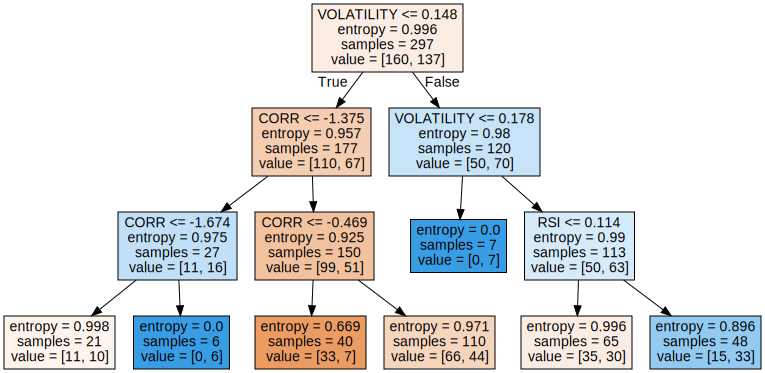

In [7]:
dot_data = tree.export_graphviz(model,  out_file=None, filled=True,feature_names=X.columns)
# To create the graph, you can uncomment
# the below line of code and run it
graphviz.Source(dot_data)

##6b) Use the Model to Predict y_pred

In [8]:
y_pred = model.predict(X_test)

In [9]:
display(y_pred)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])



---



#Step 7: Confusion Matrix and Accuracy Metric

In [10]:
def get_metrics(y_test, predicted):
    confusion_matrix_data = metrics.confusion_matrix(y_test, predicted)
    # Plot the data

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(confusion_matrix_data, fmt="d",cmap='Blues', cbar=False, annot=True, ax=ax)

    # Set the axes labels and the title
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('Actual Labels', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14)
    ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
    ax.yaxis.set_ticklabels(['No Position', 'Long Position'])

    # Display the plot
    plt.show()

    print('\n\n\n',metrics.classification_report(y_test, predicted))


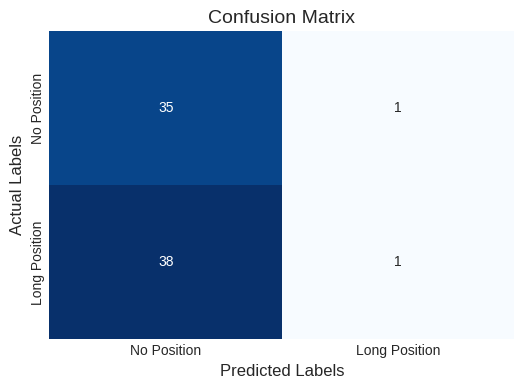




               precision    recall  f1-score   support

           0       0.48      0.97      0.64        36
           1       0.50      0.03      0.05        39

    accuracy                           0.48        75
   macro avg       0.49      0.50      0.35        75
weighted avg       0.49      0.48      0.33        75



In [11]:
get_metrics(y_test, y_pred)



---



#Step 8: Backtesting Our Model

In [12]:
ticker = 'D05.SI'
df = yf.download(ticker,start='2016-01-01', end='2017-01-01')
#we change the dates
#and is no longer called "data" but "df"

#we only want the Close price
#df = pd.DataFrame(df['Close'])
#display(df)

#Create Volatility-----------------------------------------------
df['PCT_CHANGE'] = df['Close'].pct_change()
df['VOLATILITY'] = df.rolling(14)['PCT_CHANGE'].std()*100

#Create Correlation----------------------------------------------
df['SMA'] = ta.SMA(df['Close'],14)
df['CORR'] = ta.CORREL(df['Close'], df['SMA'], 14)

#Create RSI------------------------------------------------------
df['RSI'] = ta.RSI(df['Close'].values, timeperiod=14)

#Create ADX------------------------------------------------------
df['ADX'] = ta.ADX(df['High'].values, df['Low'].values, df['Open'].values, timeperiod=14)

df = df.dropna()

#Scaling--------------------------------------------------------
df_scaled = sc.transform(df[['VOLATILITY','CORR', 'RSI', 'ADX']])

#Create a New Column
df['predicted_signal_4_tmrw'] = model.predict(df_scaled)

# Calculate the strategy returns
df['strategy_returns'] = df['predicted_signal_4_tmrw'].shift(1) * df['PCT_CHANGE']

# Drop the missing values
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


<ipython-input-12-f21583b215b5>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_signal_4_tmrw'] = model.predict(df_scaled)
<ipython-input-12-f21583b215b5>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['strategy_returns'] = df['predicted_signal_4_tmrw'].shift(1) * df['PCT_CHANGE']
<ipython-input-12-f21583b215b5>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab



---



#Step 9: Using Pyfolio

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2016-02-15
End date,2016-12-30
Total months,10
,Backtest
Annual return,25.9%
Cumulative returns,22.7%
Annual volatility,9.9%
Sharpe ratio,2.38
Calmar ratio,4.28
Stability,0.69
Max drawdown,-6.1%


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


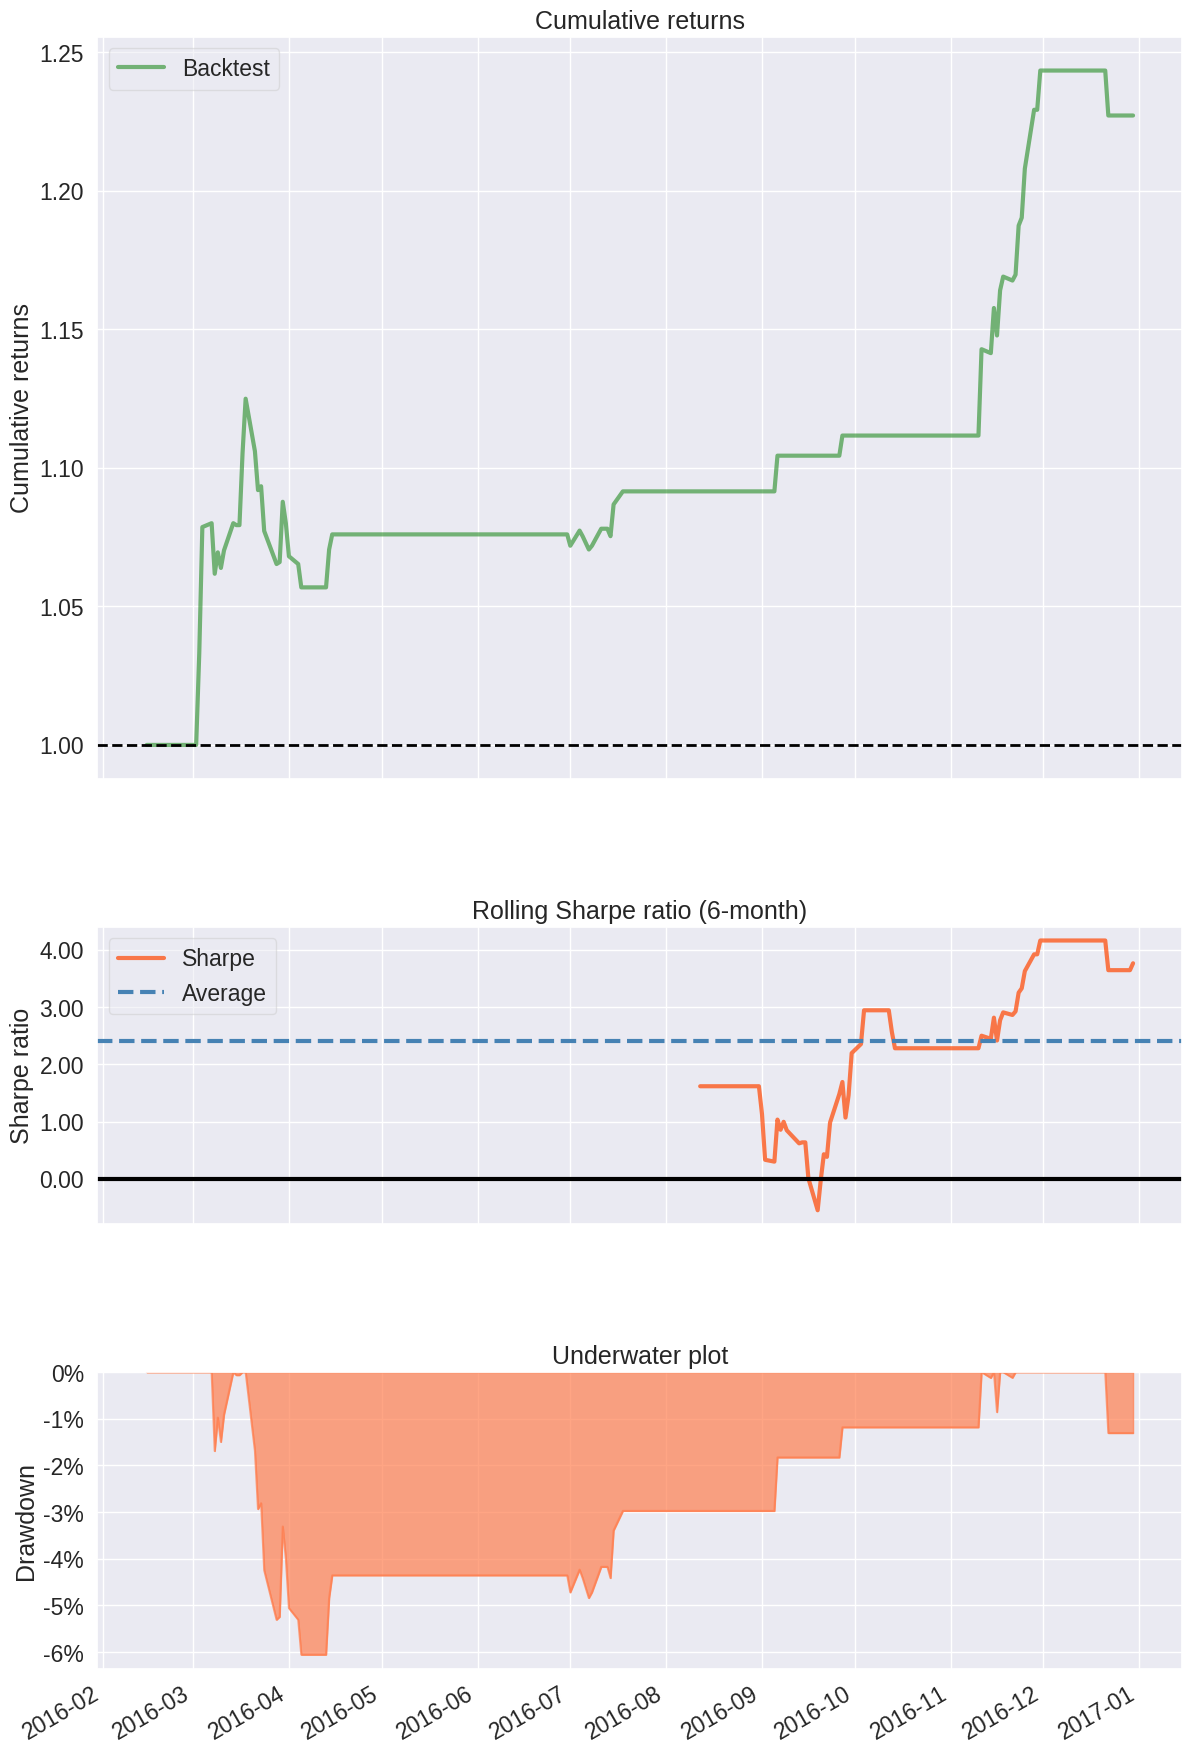

In [13]:
pf.create_simple_tear_sheet(df['strategy_returns'])



---

#THE END



---

